Paris case study

In this notebook, we focus **exclusively on Paris Airbnb listings**. We apply, compare, and interpret the core methods covered in the course:
1. **Exploratory analysis and Dimensionality reduction:** PCA (course content) and UMAP (extra method).
2. **Baseline classification models:** LDA and CART (Decision Trees).
3. **Ensemble methods:** Bootstrap, Bagging, and Random Forest.

In [ ]:
from pathlib import Path
import warnings
warnings.filterwarnings('ignore') # keep the notebook clean without red alerts

# 2. Manipulation des données
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

from sklearn.utils import resample

from sklearn.decomposition import PCA
import umap.umap_ as umap # 'umap-learn' and not 'umap'

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier


sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

Data loading and train/test split

In [2]:
DATA_PATH = "data/paris_dataset_final_ready.csv.gz" 

df_paris = pd.read_csv(DATA_PATH, compression='gzip', low_memory=False)
print(f"{df_paris.shape[1]} columns.\n")

y = df_paris['target_class']
cols_to_drop = ['target_class', 'price_clean', 'city_label']
X = df_paris.drop(columns=[col for col in cols_to_drop if col in df_paris.columns])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=123
)   # stratify to preserve class distribution in both train and test sets

print(f"\nFeatures (X) : {X.shape[1]} columns")
print(f"Target (y) : {len(y)} values")
print(f"\nClass distribution:")
print(y.value_counts().sort_index())
print(f"Train dimensions: X={X_train.shape}, y={y_train.shape}")
print(f"Test dimensions:  X={X_test.shape}, y={y_test.shape}\n")

# STANDARDIZATION
# Trees will use X_train to stay interpretable 
# PCA and UMAP will use X_train_scaled
scaler = StandardScaler()

X_train_scaled_array = scaler.fit_transform(X_train)
X_test_scaled_array = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X_test.columns, index=X_test.index)

30 colonnes.


Features (X) : 27 colonnes
Target (y) : 73111 valeurs

Distribution des classes :
target_class
0    19114
1    17449
2    18299
3    18249
Name: count, dtype: int64
Dimensions Train : X=(58488, 27), y=(58488,)
Dimensions Test  : X=(14623, 27), y=(14623,)



PCA 

In [ ]:
print("\n" + "=" * 60)
print("Method 1: PCA")
print("=" * 60)

#pca
pca_full = PCA()
pca_full.fit(X_train_std)

#explained variance
var_exp = pca_full.explained_variance_ratio_
var_cum = np.cumsum(var_exp) #cumulative explained variance

#number of components
n_comp_95 = np.argmax(var_cum >= 0.95) + 1
n_comp_90 = np.argmax(var_cum >= 0.90) + 1

print(f"\nPCA results")
print(f"components for 90% variance: {n_comp_90}/{X.shape[1]}")
print(f"components for 95% variance: {n_comp_95}/{X.shape[1]}")
print(f"possible reduction: {(1 - n_comp_95/X.shape[1])*100:.1f}%")

#screeplot
plt.figure(figsize=(10, 6))
plt.bar(range(1, min(21, len(var_exp)+1)), var_exp[:20], alpha=0.7, edgecolor='black')
plt.title("scree plot")
plt.xlabel("component")
plt.ylabel("explained variance")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

This scree plot displays the explained variance for the first 20 components of the PCA performed on the standardized Paris dataset. The first two components are the most significant, accounting for approximately 16.5% and 13% of the variance respectively, suggesting that the primary differences between Paris listings are captured in these initial dimensions. The elbow appears at component 5, although in order to capture at least 95% of the information we need the first 20 principal components.

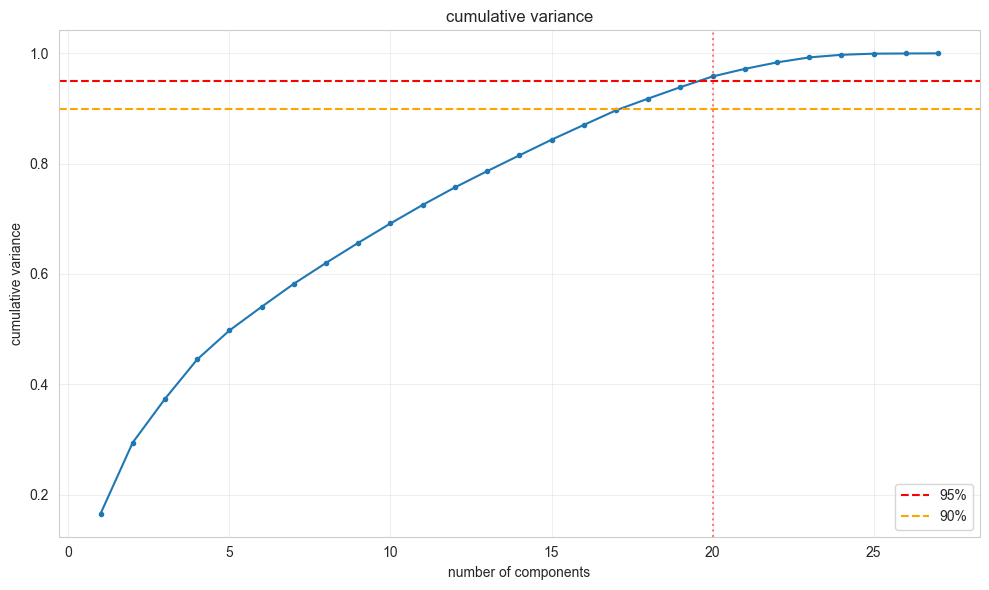

In [ ]:
#cumulative variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(var_cum)+1), var_cum, marker='o', markersize=3)
plt.axhline(y=0.95, color='r', linestyle='--', label='95%')
plt.axhline(y=0.90, color='orange', linestyle='--', label='90%')
plt.axvline(x=n_comp_95, color='r', linestyle=':', alpha=0.5)
plt.title("cumulative variance")
plt.xlabel("number of components")
plt.ylabel("cumulative variance")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The cumulative variance plot shows the "cost" of dimensionality reduction: while the first few components capture the main trends, you need 20 components to retain 95% of the original information as found previously. To avoid losing significant detail about the listings, a model should likely use at least the first 20 components.

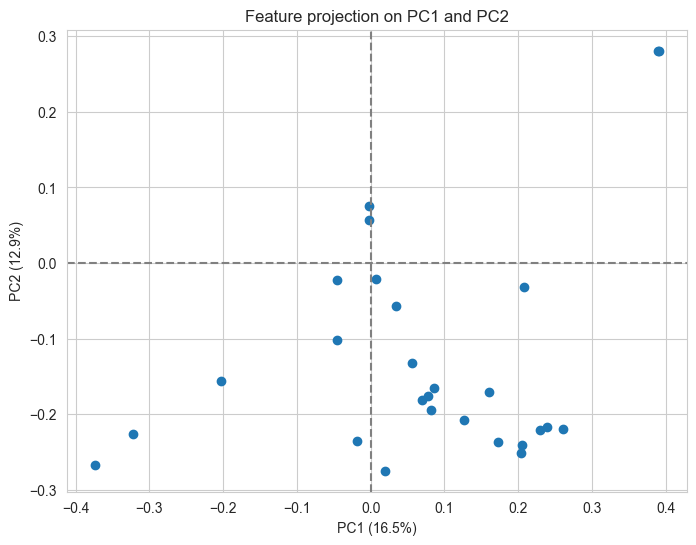

In [ ]:
#plot features projection on PC1 and PC2 axes
plt.figure(figsize=(8,6))
plt.scatter(pca_full.components_[0], pca_full.components_[1])
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
pc1_pct = pca_full.explained_variance_ratio_[0]*100
pc2_pct = pca_full.explained_variance_ratio_[1]*100
plt.xlabel(f'PC1 ({pc1_pct:.1f}%)')
plt.ylabel(f'PC2 ({pc2_pct:.1f}%)')
plt.title('Feature projection on PC1 and PC2')
plt.show()

Features far to the right or left on the PC1 axis are the primary drivers of listing diversity that in this case will certainly be the size, while those high or low on PC2 represent secondary characteristics, which are mainly grouped in the lower half. The isolation of certain points suggests specific attributes that represent unique units, such as the outlier in the top-right quadrant which likely represents a specific listing category that scales uniquely with both components.

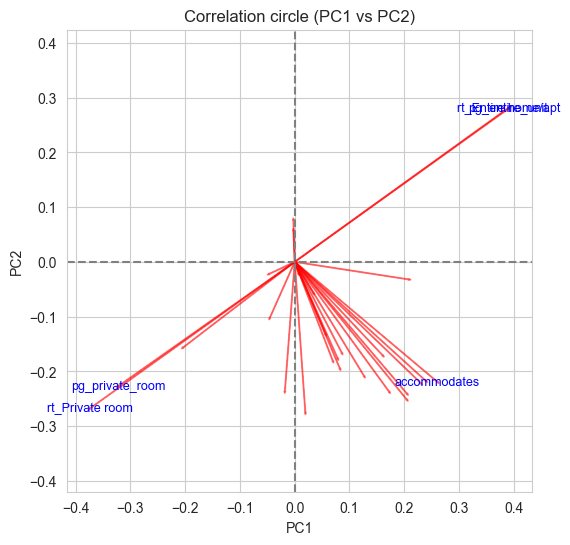

In [ ]:
#correlation circle for PC1 and PC2 
plt.figure(figsize=(6,6))
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
vecs = pca_full.components_[:2]
corrs = np.linalg.norm(vecs, axis=0)
top_idx = np.argsort(corrs)[-5:] #top 5 features with highest correlation to PC1/PC2
for i in range(len(X.columns)):
    plt.arrow(0, 0, vecs[0,i], vecs[1,i], color='r', alpha=0.5)
for i in top_idx:
    plt.text(vecs[0,i], vecs[1,i], X.columns[i], fontsize=9, ha='center', va='center', color='blue')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Correlation circle (PC1 vs PC2)')
plt.axis('equal')
plt.show()

This correlation circle explicitly labels the variables driving the PCA, revealing a clear opposition in the Paris market: "rt_Entire home/apt" correlates positively with both PC1 and PC2, while "rt_Private room" and "pg_private_room" show a strong negative correlation. This indicates that the first two components effectively distinguish between renting an entire unit versus a private room. Variables like "accommodates" cluster in the lower-right, showing that listing capacity is a major factor in PC1 but moves inversely to the factors driving PC2.


 top 10 features PC1:
            feature  loading
 rt_Entire home/apt 0.390591
     pg_entire_unit 0.389621
    rt_Private room 0.373965
    pg_private_room 0.321908
       accommodates 0.260369
 score_chef_kitchen 0.239377
     has_dishwasher 0.230193
has_washing_machine 0.207927
               beds 0.204739
           bedrooms 0.204361

 top 10 features PC2:
           feature  loading
    pg_entire_unit 0.280815
rt_Entire home/apt 0.280051
  standing_thermal 0.274720
   rt_Private room 0.267624
          bedrooms 0.251118
              beds 0.240387
     bathrooms_qty 0.236820
            has_ac 0.235758
   pg_private_room 0.226700
    has_dishwasher 0.221277


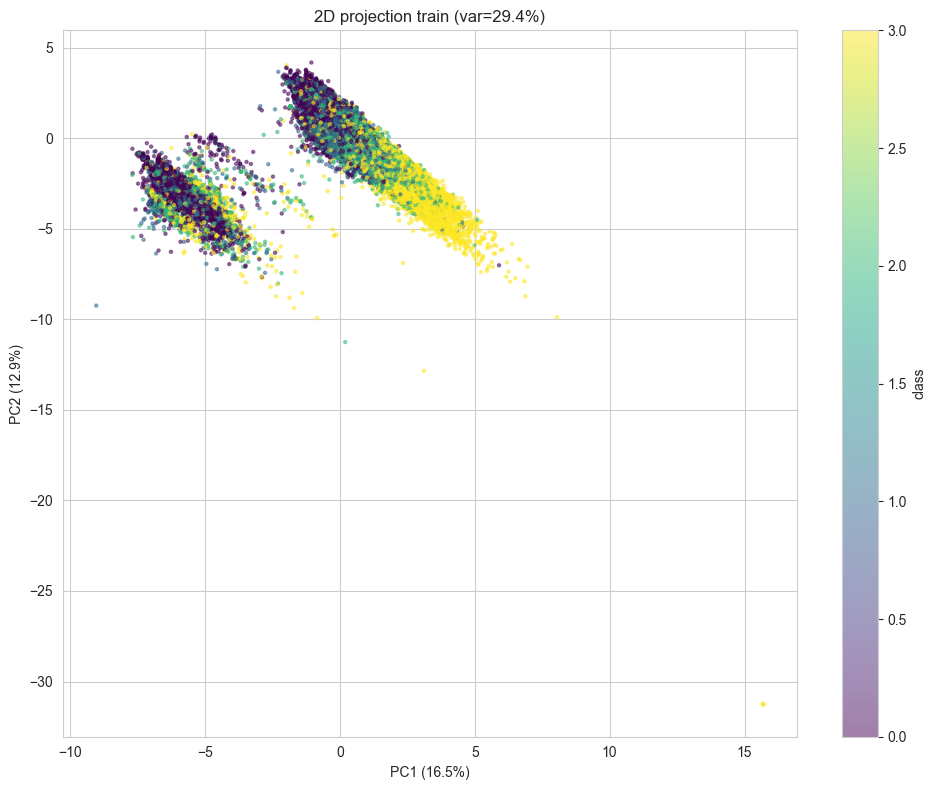

In [ ]:
#2D projection
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train_std)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1], 
                     c=y_train, cmap='viridis', s=5, alpha=0.5)
plt.title(f"2D projection train (var={pca_2d.explained_variance_ratio_.sum():.1%})")
plt.xlabel(f"PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})")
plt.colorbar(scatter, label='class')
plt.tight_layout()

#feature importance PC1
pc1_loadings = pd.DataFrame({
    'feature': X.columns,
    'loading': np.abs(pca_full.components_[0])
}).sort_values('loading', ascending=False)

print(f"\n top 10 features PC1:")
print(pc1_loadings.head(10).to_string(index=False))

#feature importance PC2
pc2_loadings = pd.DataFrame({
    'feature': X.columns,
    'loading': np.abs(pca_full.components_[1])
}).sort_values('loading', ascending=False)

print(f"\n top 10 features PC2:")
print(pc2_loadings.head(10).to_string(index=False))

PC1 represents a "scale" axis that separates the Paris market by rental type and capacity. The top features Entire home/apt and Private room drive the distinct two cluster split seen in the 2D projection. This confirms that the listing's target_class is fundamentally determined by whether the property is a large, fully-equipped unit or a smaller shared space.

The projection maps the individual listings into PC space, color coded by their target_class. The distinct separation into two clusters, a dense group on the left and an elongated group on the right proves that PC1 is highly effective at identifying structural differences between listing types. The color gradient shows that higher class values (yellow) are predominantly located in the right-hand cluster, suggesting that the features with high PC1 loadings (like "entire home" or "accommodates") are the strongest predictors of the listing's class.

UMAP : to be completed

LDA

Accuracy: 48.61%
Confusion matrix: 
[[2421  918  407   77]
 [1121 1197  911  261]
 [ 580  788 1441  851]
 [ 334  362  905 2049]]


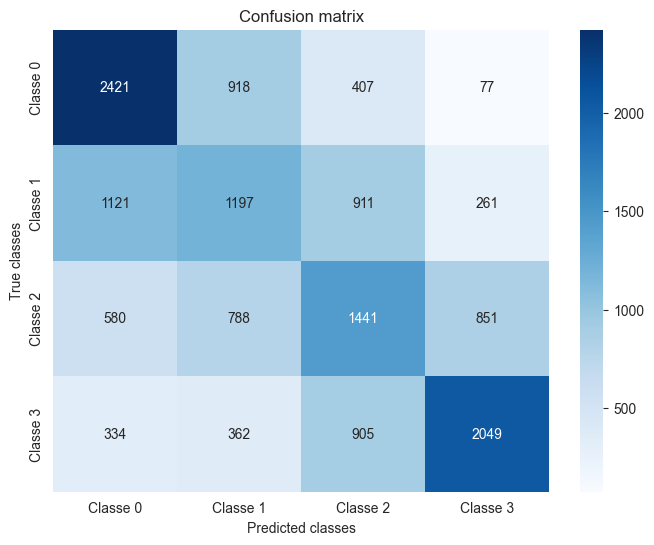

In [ ]:
#LDA 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#test set predicted classes
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

#accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")

#confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion matrix: \n{cm}")

#visualization 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Classe {i}' for i in range(4)],
            yticklabels=[f'Classe {i}' for i in range(4)])
plt.title('Confusion matrix')
plt.xlabel('Predicted classes')
plt.ylabel('True classes')
plt.show()


This matrix shows that the data is already able to spot extremes, even if the middle ground is still a bit confusionary. The model can easily identify the cheapest apartments (Class 0: 2421 correct) and the most expensive ones (Class 3: 2049 correct) because of their distinct features. There is a significant overlap between Classes 1 and 2.


LDA Method
Reduced dimensions: 27 → 3
Explained variance: [0.90665568 0.08597618 0.00736814]


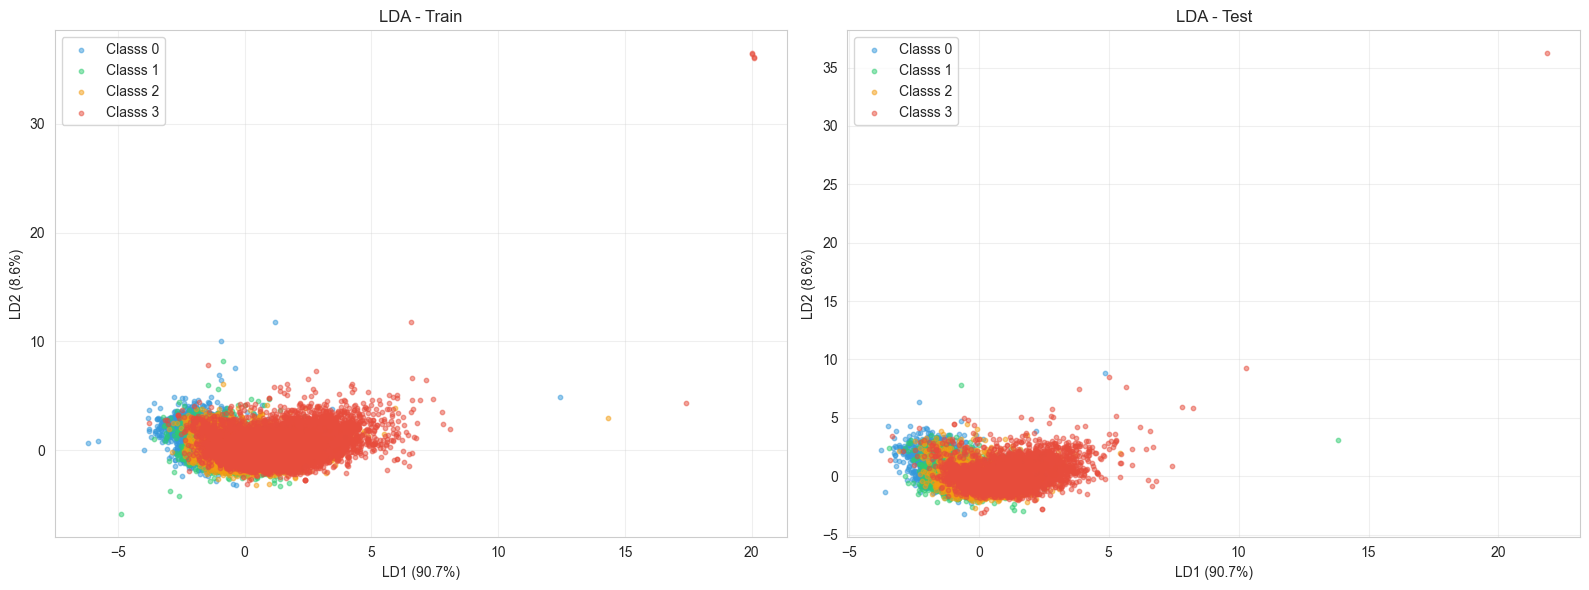

In [ ]:
#LDA
colors_class = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']

print("\n" + "=" * 60)
print("LDA Method")
print("=" * 60)

lda = LinearDiscriminantAnalysis(n_components=3) #3 composantes pour 4 classes
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

print(f"Reduced dimensions: {X_train.shape[1]} → {X_train_lda.shape[1]}")
print(f"Explained variance: {lda.explained_variance_ratio_}")

#2D visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, (X_lda, y_set, title) in zip(axes, 
    [(X_train_lda, y_train, 'Train'), (X_test_lda, y_test, 'Test')]):
    
    for classe in range(4):
        mask = y_set == classe
        ax.scatter(X_lda[mask, 0], X_lda[mask, 1], 
                  c=colors_class[classe], label=f'Classs {classe}', alpha=0.5, s=10)
    
    ax.set_title(f"LDA - {title}")
    ax.set_xlabel(f"LD1 ({lda.explained_variance_ratio_[0]:.1%})")
    ax.set_ylabel(f"LD2 ({lda.explained_variance_ratio_[1]:.1%})")
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

The plots reveal a clean color transition along the first axis, which carries 90.7% of the model's discriminatory power. The price classes, shifting from blue to red, follow a very orderly sequence, proving that Paris apartment prices follow a strong linear logic. 

The second axis accounts for only 8.6% of the useful information for separating the classes. Visually, this creates a "squashed" effect: the data points are widely spread out horizontally but tightly bunched vertically. This tells us that the variables truly distinguishing a "budget" apartment from a "luxury" one are almost entirely captured by LD1, likely taking into account square footage and neighborhood, while other features don't contribute much to refining the classification.

The striking similarity between the Train and Test plots confirms that the model is robust and isn't suffering from overfitting. You can also spot a few isolated points on the far right: these are outliers representing the ultra-luxury segment of the Paris market. Their distance from the rest of the pack shows just how different these properties are from the standard market.

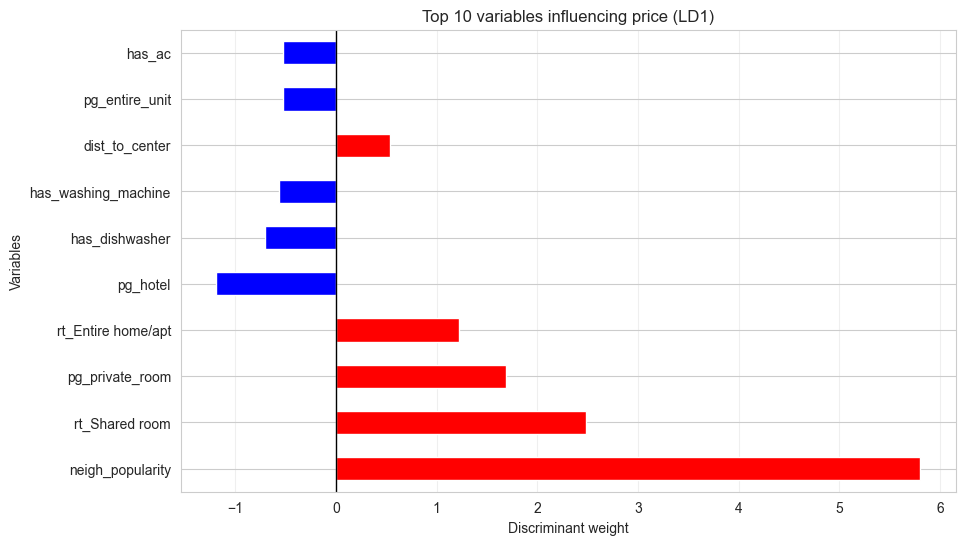

In [ ]:
#LD1 coefficients 
coeffs_ld1 = pd.Series(lda.coef_[0], index=X.columns)

#sorting
top_features = coeffs_ld1.abs().sort_values(ascending=False).head(10) #top 10 features
top_coeffs = coeffs_ld1.loc[top_features.index]

#plot
plt.figure(figsize=(10, 6))
top_coeffs.plot(kind='barh', color=['red' if x > 0 else 'blue' for x in top_coeffs])
plt.title("Top 10 variables influencing price (LD1)")
plt.xlabel("Discriminant weight")
plt.ylabel("Variables")
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.show()


The analysis demonstrates that the real estate market is structured in a linear ways. The clear visual separation between groups, confirmed by the test data, proves the model's robustness and identifies neighborhood popularity and accommodation type as the primary drivers of value. While the middle market segments show some similarities, luxury properties stand out radically.

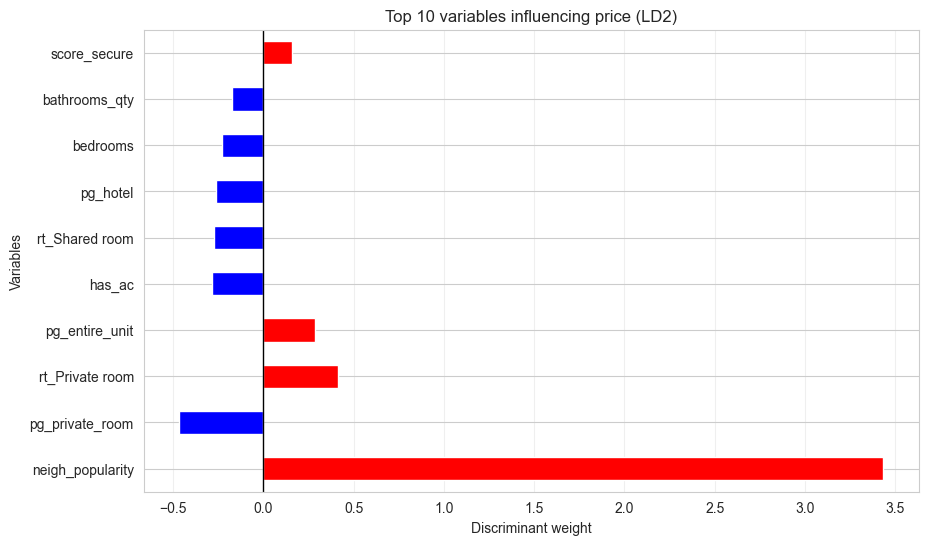

In [ ]:
#LD2 coefficients 
coeffs_ld1 = pd.Series(lda.coef_[1], index=X.columns)

#sorting
top_features = coeffs_ld1.abs().sort_values(ascending=False).head(10)
top_coeffs = coeffs_ld1.loc[top_features.index]

#plot
plt.figure(figsize=(10, 6))
top_coeffs.plot(kind='barh', color=['red' if x > 0 else 'blue' for x in top_coeffs])
plt.title("Top 10 variables influencing price (LD2)")
plt.xlabel("Discriminant weight")
plt.ylabel("Variables")
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.grid(axis='x', alpha=0.3)
plt.show()


While the second axis is secondary accounting for only 8.6% of the explained variance it reveals several nuances that complement the geographic dimension. Although neighborhood popularity remains a dominant positive factor, this axis is distinguished by the negative influence of variables related to capacity, such as the number of bedrooms or bathrooms. This suggests that LD2 captures a contrast between highly popular but potentially smaller units and larger properties whose value isn't purely location driven. 

In [ ]:
#LDA coordinates
lda_coords = pd.DataFrame(X_train_lda, columns=[f'LD{i+1}' for i in range(X_train_lda.shape[1])])

#correlations between X_train and the LD axes
structure_matrix = pd.concat([X_train.reset_index(drop=True), lda_coords], axis=1).corr()
final_corr = structure_matrix.loc[X.columns, ['LD1', 'LD2']]

print(final_corr)


                             LD1       LD2
accommodates            0.835905  0.100482
bedrooms                0.791398  0.294905
beds                    0.575632  0.114134
minimum_nights_avg_ntm -0.161780  0.209805
number_of_reviews      -0.115761 -0.089139
dist_to_center         -0.043559  0.302325
bathrooms_qty           0.564270  0.543842
has_ac                  0.314972  0.017732
has_elevator            0.175487 -0.060298
has_dishwasher          0.442307 -0.318149
has_parking             0.107539  0.028797
has_balcony             0.138188 -0.025842
has_washing_machine     0.285634 -0.226646
standing_thermal        0.297028 -0.045701
score_chef_kitchen      0.190397 -0.251545
score_coffee            0.115681 -0.202839
score_wellness          0.304956  0.048095
score_work              0.191816 -0.069765
score_view              0.065100 -0.019255
score_secure           -0.117640 -0.283637
neigh_popularity       -0.198406  0.027439
pg_entire_unit          0.165839 -0.329068
pg_hotel   

The LD1 axis is (unsurprisingly) driven by guest capacity and property size, showing strong correlations for accommodates (0.84) and bedrooms (0.79). This confirms that the primary factor in the Paris real estate pricing is derives from physical space. In contrast, the LD2 axis captures an interesting relatioshinp between management style and configuration. It correlates positively with private rooms and distance from the city center, while showing a negative relationship with entire homes and specific amenities like dishwashers.

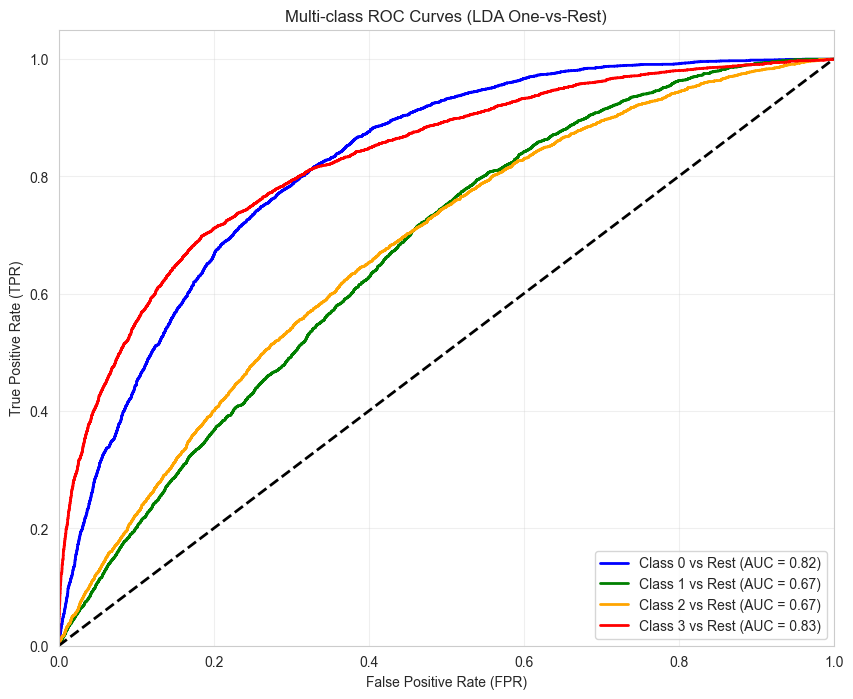

In [ ]:
#ROC curves
#one vs rest per class to evaluate performance by quartile

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

#binarize the target 
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]

#get predicted probabilities from LDA
y_score = lda.predict_proba(X_test)

#compute and plot curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'orange', 'red']

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'Class {i} vs Rest (AUC = {roc_auc:.2f})')

#chart styling
plt.plot([0, 1], [0, 1], 'k--', lw=2) #randomization
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Multi-class ROC Curves (LDA One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


The ROC curves confirm the model’s predictive power, especially for the extreme ends of the market. Classes 0 and 3 display the most convex curves and the highest AUC scores, indicating that the model isolates these categories from the rest of the dataset efficiently. However, Classes 1 and 2 show slightly lower performance with curves closer to the confusion matrix observed earlier. 

CART 

METHOD: CART
Accuracy: 45.70%


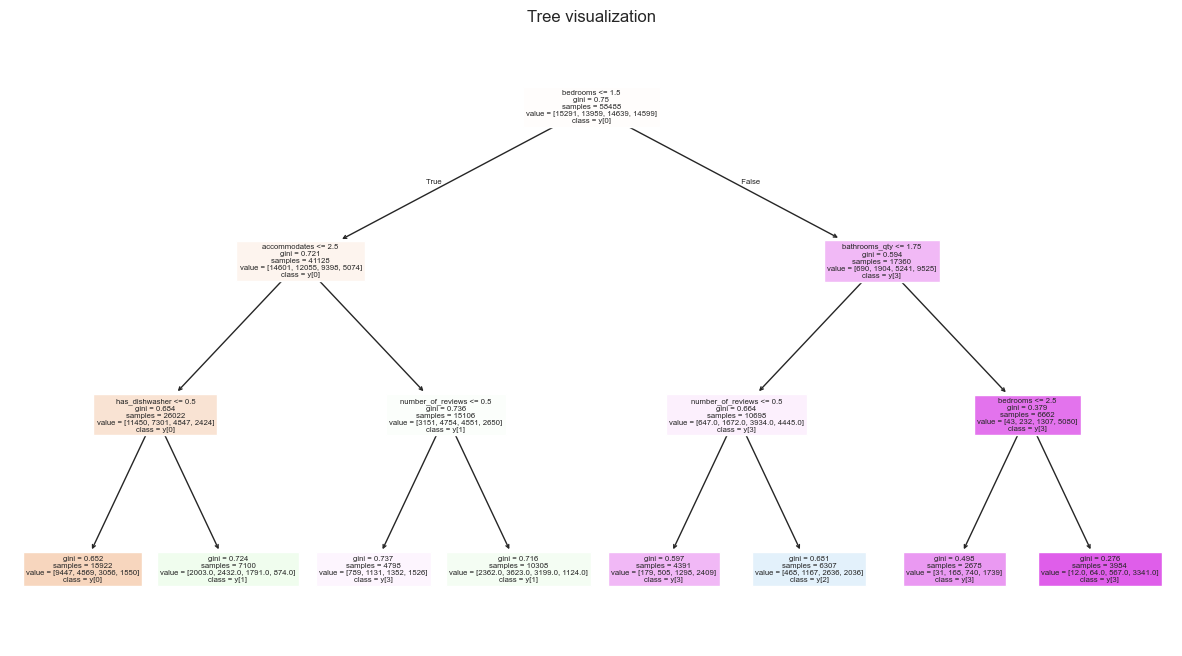

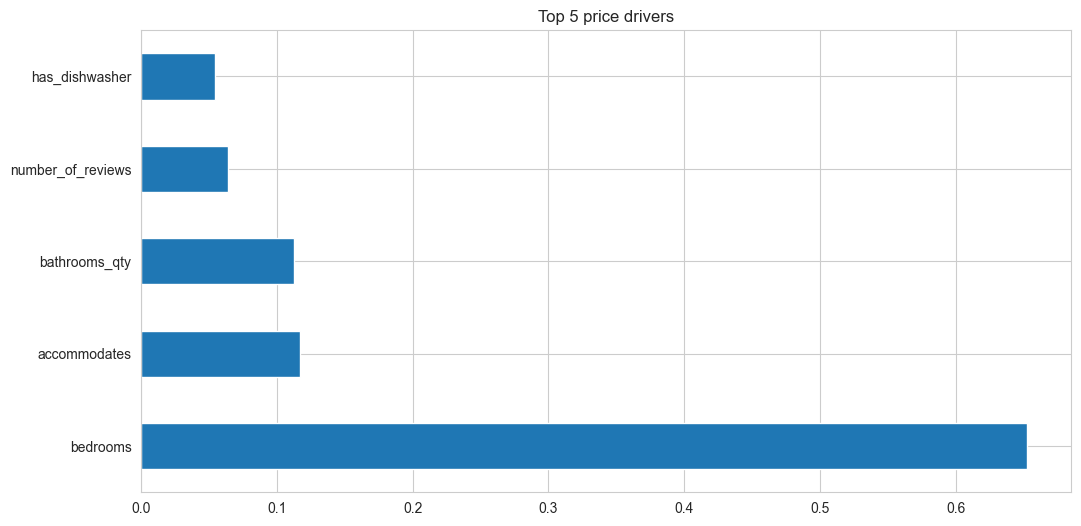

In [ ]:
print("=" * 60)
print("METHOD: CART")
print("=" * 60)

#train 
cart = DecisionTreeClassifier(max_depth=3, random_state=42) #a depth of 3 keeps the tree simple enough to read
cart.fit(X_train, y_train)

#evaluation
y_pred = cart.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")

#visualizing the tree
plt.figure(figsize=(15, 8))
plot_tree(cart, feature_names=X.columns, filled=True, class_names=True)
plt.title("Tree visualization")
plt.show()

#feature mportance
importance = pd.Series(cart.feature_importances_, index=X.columns).sort_values(ascending=False)
importance.head(5).plot(kind='barh', title="Top 5 price drivers")
plt.show()

The decision tree visualization reveals a hierarchical logic for price classification. At the top of the tree, the root node based on size or capacity separates the major price categories. As you move down the branches, the model refines its predictions by layering secondary factors like neighborhood popularity or specific amenities.

The feature importance plot highlights the five most influential variables that drive the classification of apartment prices, clearly showing what impacts market value and we can see that physical capacity and geographic aera typically dominate the model's logic as in LDA. It effectively cuts through the noise of the many available features, confirming that while amenities and layout matter, price is mainly driven by the size of the unit and its desirability in the city.

The largest alpha that stays above the cutoff is: 0.00153


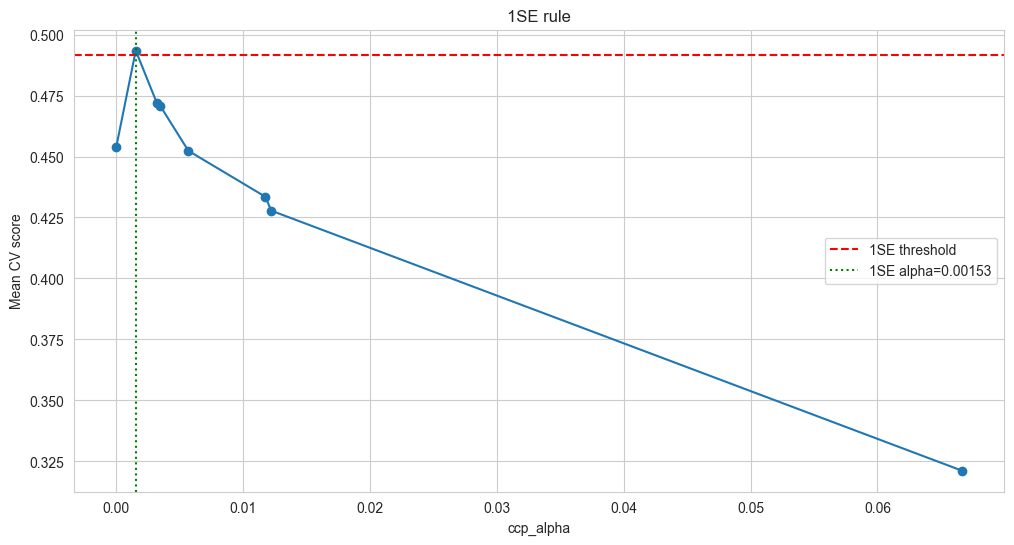

Pruned Tree Accuracy: 48.45%


In [ ]:
#cost complexity path
from sklearn.model_selection import cross_val_score


path = cart.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

#finding the best alpha
scores_means = []
scores_stds = []

for alpha in ccp_alphas:
    cv_scores = cross_val_score(DecisionTreeClassifier(ccp_alpha=alpha), X_train, y_train, cv=5)
    scores_means.append(cv_scores.mean())
    scores_stds.append(cv_scores.std())

#1-SE Rule
best_idx = np.argmax(scores_means)
cutoff = scores_means[best_idx] - scores_stds[best_idx]

#largest alpha that stays above the cutoff
optimal_alpha = max([alpha for i, alpha in enumerate(ccp_alphas) if scores_means[i] >= cutoff])
print(f"The largest alpha that stays above the cutoff is: {optimal_alpha:.5f}")

#plot
plt.plot(ccp_alphas, scores_means, marker='o')
plt.axhline(cutoff, color='red', linestyle='--', label='1SE threshold')
plt.axvline(optimal_alpha, color='green', linestyle=':', label=f'1SE alpha={optimal_alpha:.5f}')
plt.xlabel('ccp_alpha')
plt.ylabel('Mean CV score')
plt.title('1SE rule')
plt.legend()
plt.show()

#pruned tree
pruned_cart = DecisionTreeClassifier(ccp_alpha=optimal_alpha, random_state=42)
pruned_cart.fit(X_train, y_train)

print(f"Pruned Tree Accuracy: {pruned_cart.score(X_test, y_test):.2%}")

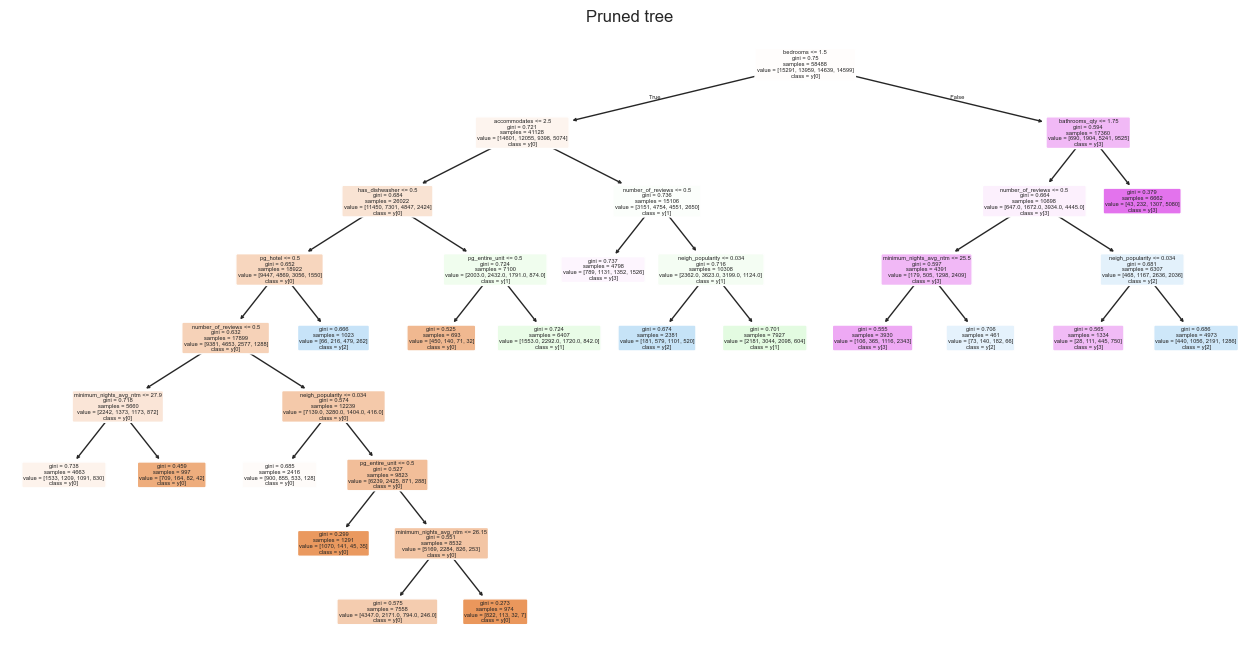

In [ ]:
#pruned tree
plt.figure(figsize=(16, 8))
plot_tree(pruned_cart, 
          feature_names=X.columns, 
          class_names=True, 
          filled=True, 
          rounded=True)

plt.title("Pruned tree")
plt.show()

Final Model Accuracy: 48.45%


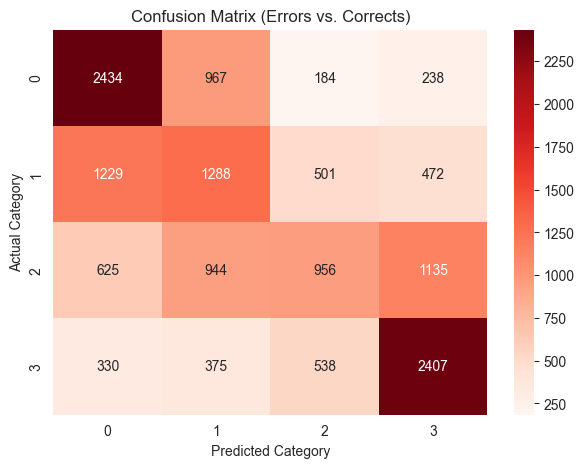

In [ ]:
#pridiction using the pruned model
y_pred = pruned_cart.predict(X_test)

#score
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")

#Heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Reds')
plt.title("Confusion matrix")
plt.xlabel("Predicted category")
plt.ylabel("Actual category")
plt.show()

An accuracy of 48.45% indicates that while the model performs better than just random guessing it still struggles to clearly differentiate between all price segments. This performance level suggests that the decision tree is able to capture the characteristics of the extreme categories between the very cheap and the very expensive, but finds the "middle-class" apartments too similar to separate with its algorithm. In a complex market like the Parisian one, where a small studio in a luxury district can cost as much as a large flat in a suburban area, the nearly 50% accuracy confirms that physical features alone can't completely differenciate the market, and the noise within the intermediate market is significant.

The performance of the LDA and the CART algorithm are similar, suggesting that the bottleneck in prediction lies in the data's characteristics rather than the algorithm used. Despite the difference between the two models, they both do a good job at the extremes (Classes 0 and 3) while witnessing a fading performance over the middle ground. This convergence in accuracy confirms that the intermediate price segments in Paris are not cleanly separable by either straight lines or simple decision rules, likely requiring more complex models in order to break the 50% barrier.

Bootstrapping and Bagging : to be completed

In [ ]:
df_model = df.copy()
le = LabelEncoder()
for col in df_model.select_dtypes(include=['object', 'category']).columns:
    df_model[col] = le.fit_transform(df_model[col].astype(str))

drop_cols = [c for c in [ 'price_clean', 'target_class'] if c in df_model.columns]
X = df_model.drop(columns=drop_cols).select_dtypes(include=[np.number])
X = X.fillna(X.median())
y = df['target_class'].values

CLASS_COLORS = ['#2196F3', '#4CAF50', '#FF9800', '#F44336']
CLASS_LABELS = ['Cl.0 – Très bas', 'Cl.1 – Bas-moyen', 'Cl.2 – Haut-moyen', 'Cl.3 – Très haut']
CLASS_SHORT  = ['Cl.0', 'Cl.1', 'Cl.2', 'Cl.3']

print(f"✅ Dataset : {df.shape[0]} observations × {X.shape[1]} features")
print(f"   Distribution de target_class :")
for c in range(4):
    print(f"     Classe {c} : {np.sum(y==c):>5d} obs. ({np.mean(y==c)*100:.1f}%)")

X_train, X_test, y_train, y_test = train_test_split(
    X.values, y, test_size=0.3, random_state=42, stratify=y
)


✅ Dataset : 73111 observations × 22 features
   Distribution de target_class :
     Classe 0 : 19114 obs. (26.1%)
     Classe 1 : 17449 obs. (23.9%)
     Classe 2 : 18299 obs. (25.0%)
     Classe 3 : 18249 obs. (25.0%)


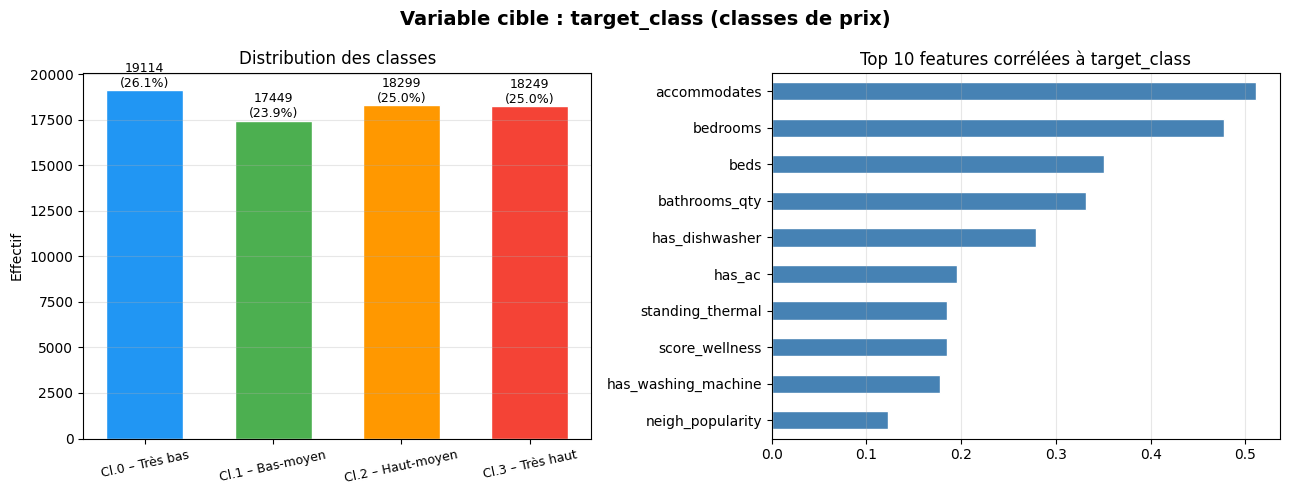

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle("Variable cible : target_class (classes de prix)", fontsize=14, fontweight='bold')

counts = pd.Series(y).value_counts().sort_index()
bars = axes[0].bar(range(4), counts.values, color=CLASS_COLORS, edgecolor='white', width=0.6)
axes[0].set_xticks(range(4))
axes[0].set_xticklabels(CLASS_LABELS, rotation=12, fontsize=9)
axes[0].set_ylabel("Effectif")
axes[0].set_title("Distribution des classes")
for bar, v in zip(bars, counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, v + 5,
                 f'{v}\n({v/len(y)*100:.1f}%)', ha='center', va='bottom', fontsize=9)
axes[0].grid(axis='y', alpha=0.3)

# Prix moyen par classe (si disponible)
if 'prix' in df.columns:
    prix_by_class = [df[df['target_class'] == c]['prix'].values for c in range(4)]
    bp = axes[1].boxplot(prix_by_class, patch_artist=True, labels=CLASS_SHORT)
    for patch, color in zip(bp['boxes'], CLASS_COLORS):
        patch.set_facecolor(color); patch.set_alpha(0.7)
    axes[1].set_title("Distribution du prix par classe")
    axes[1].set_ylabel("Prix")
    axes[1].grid(axis='y', alpha=0.3)
else:
    # Heatmap des corrélations top features avec target
    corr = pd.DataFrame(X, columns=X.columns if hasattr(X, 'columns') else range(X.shape[1]))
    top_feat = pd.DataFrame(X, columns=df_model.drop(columns=drop_cols)
                            .select_dtypes(include=[np.number]).columns)
    top_feat['target'] = y
    top_corr = top_feat.corr()['target'].drop('target').abs().sort_values(ascending=False).head(10)
    top_corr.plot(kind='barh', ax=axes[1], color='steelblue', edgecolor='white')
    axes[1].set_title("Top 10 features corrélées à target_class")
    axes[1].invert_yaxis()
    axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


═════════════════════════════════════════════════════════════════
  BOOTSTRAP — Stabilité de target_class
═════════════════════════════════════════════════════════════════
  Moyenne observée : 1.4881
  IC 95% bootstrap : [1.4806 ; 1.4951]

  IC 95% des proportions par classe :
    Classe 0 : 0.261 ± 0.0016  IC95% [0.258 ; 0.264]
    Classe 1 : 0.239 ± 0.0016  IC95% [0.236 ; 0.242]
    Classe 2 : 0.250 ± 0.0016  IC95% [0.247 ; 0.253]
    Classe 3 : 0.250 ± 0.0016  IC95% [0.247 ; 0.253]


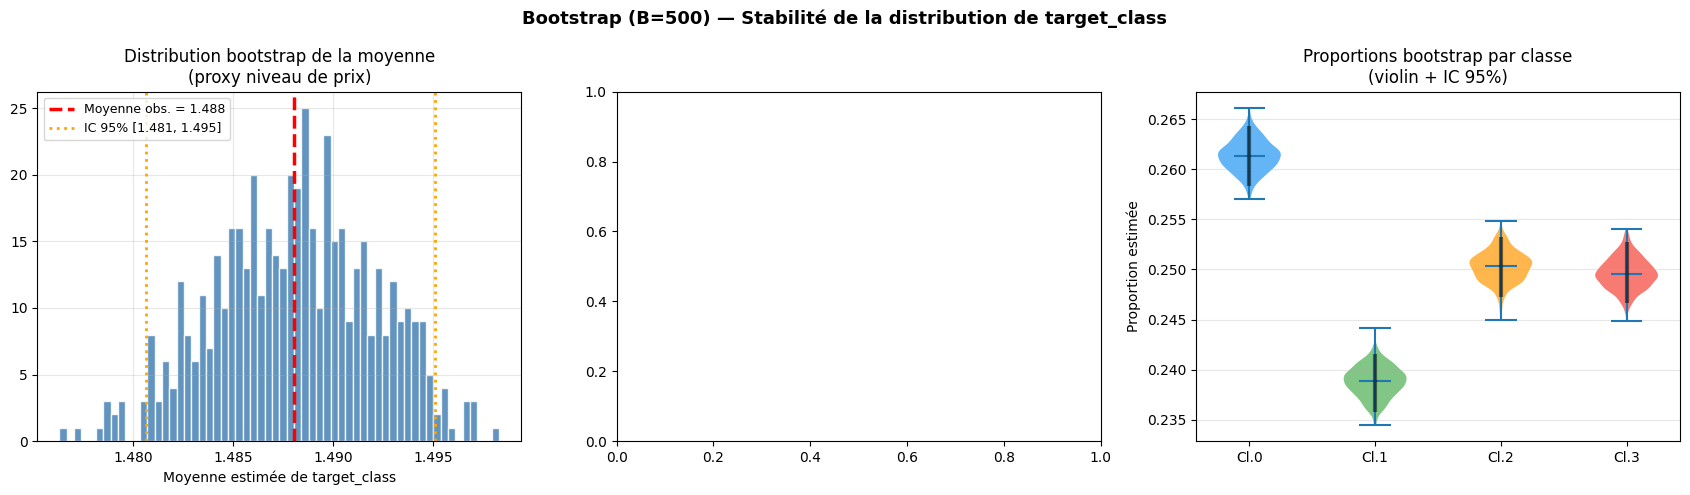

In [ ]:
print("\n" + "═"*65)
print("  BOOTSTRAP — Stabilité de target_class")
print("═"*65)

N_BOOT = 500
bootstrap_props  = {c: [] for c in range(4)}
bootstrap_means  = []

for _ in range(N_BOOT):
    s = resample(y, replace=True, n_samples=len(y))
    bootstrap_means.append(np.mean(s))
    for c in range(4):
        bootstrap_props[c].append(np.mean(s == c))

bootstrap_means = np.array(bootstrap_means)
ci_low  = np.percentile(bootstrap_means, 2.5)
ci_high = np.percentile(bootstrap_means, 97.5)

print(f"  Moyenne observée : {np.mean(y):.4f}")
print(f"  IC 95% bootstrap : [{ci_low:.4f} ; {ci_high:.4f}]")
print(f"\n  IC 95% des proportions par classe :")
for c in range(4):
    p = np.array(bootstrap_props[c])
    print(f"    Classe {c} : {p.mean():.3f} ± {p.std():.4f}  "
          f"IC95% [{np.percentile(p,2.5):.3f} ; {np.percentile(p,97.5):.3f}]")

fig2, axes2 = plt.subplots(1, 3, figsize=(17, 5))
fig2.suptitle(f"Bootstrap (B={N_BOOT}) — Stabilité de la distribution de target_class",
              fontsize=13, fontweight='bold')

# Histogramme de la moyenne bootstrap
axes2[0].hist(bootstrap_means, bins=60, color='steelblue', edgecolor='white', alpha=0.85)
axes2[0].axvline(np.mean(y), color='red',    lw=2.5, linestyle='--',
                 label=f'Moyenne obs. = {np.mean(y):.3f}')
axes2[0].axvline(ci_low,     color='orange', lw=2,   linestyle=':',
                 label=f'IC 95% [{ci_low:.3f}, {ci_high:.3f}]')
axes2[0].axvline(ci_high,    color='orange', lw=2,   linestyle=':')
axes2[0].set_title("Distribution bootstrap de la moyenne\n(proxy niveau de prix)")
axes2[0].set_xlabel("Moyenne estimée de target_class")
axes2[0].legend(fontsize=9)
axes2[0].grid(alpha=0.3)

# Violin plot des proportions par classe
vp_data = [bootstrap_props[c] for c in range(4)]
parts = axes2[2].violinplot(vp_data, positions=range(4), showmedians=True,
                            showextrema=True)
for i, (body, color) in enumerate(zip(parts['bodies'], CLASS_COLORS)):
    body.set_facecolor(color); body.set_alpha(0.7)
# IC 95%
for c in range(4):
    p = np.array(bootstrap_props[c])
    axes2[2].vlines(c, np.percentile(p, 2.5), np.percentile(p, 97.5),
                    color='black', lw=3, alpha=0.5)
axes2[2].set_xticks(range(4))
axes2[2].set_xticklabels(CLASS_SHORT)
axes2[2].set_title("Proportions bootstrap par classe\n(violin + IC 95%)")
axes2[2].set_ylabel("Proportion estimée")
axes2[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()



═════════════════════════════════════════════════════════════════
  BAGGING — Convergence OOB selon B
═════════════════════════════════════════════════════════════════
  CART seul (erreur test) : 0.5462
  OOB minimale : 0.4598  (B=295)


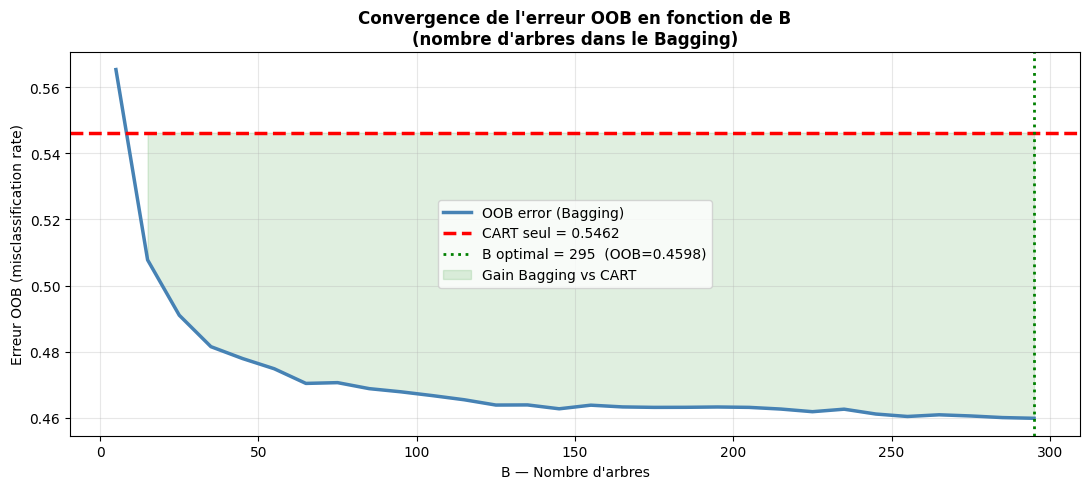

In [ ]:
print("\n" + "═"*65)
print("  BAGGING — Convergence OOB selon B")
print("═"*65)

B_range  = list(range(5, 301, 10))
oob_errs = []

for b_val in B_range:
    bag_tmp = BaggingClassifier(
        estimator=DecisionTreeClassifier(),
        n_estimators=b_val,
        bootstrap=True, oob_score=True,
        random_state=42, n_jobs=-1
    )
    bag_tmp.fit(X_train, y_train)
    oob_errs.append(1 - bag_tmp.oob_score_)

# Erreur de test CART seul
cart_ref = DecisionTreeClassifier(random_state=42)
cart_ref.fit(X_train, y_train)
err_cart_ref = 1 - accuracy_score(y_test, cart_ref.predict(X_test))
print(f"  CART seul (erreur test) : {err_cart_ref:.4f}")

# B optimal
best_B   = B_range[np.argmin(oob_errs)]
best_oob = min(oob_errs)
print(f"  OOB minimale : {best_oob:.4f}  (B={best_B})")

fig3, ax3 = plt.subplots(figsize=(11, 5))
ax3.plot(B_range, oob_errs, color='steelblue', lw=2.5, label='OOB error (Bagging)')
ax3.axhline(err_cart_ref, color='red', linestyle='--', lw=2.5,
            label=f'CART seul = {err_cart_ref:.4f}')
ax3.axvline(best_B, color='green', linestyle=':', lw=2,
            label=f'B optimal = {best_B}  (OOB={best_oob:.4f})')
ax3.fill_between(B_range, oob_errs, err_cart_ref,
                 where=[o < err_cart_ref for o in oob_errs],
                 alpha=0.12, color='green', label='Gain Bagging vs CART')
ax3.set_title("Convergence de l'erreur OOB en fonction de B\n(nombre d'arbres dans le Bagging)",
              fontsize=12, fontweight='bold')
ax3.set_xlabel("B — Nombre d'arbres")
ax3.set_ylabel("Erreur OOB (misclassification rate)")
ax3.legend(fontsize=10)
ax3.grid(alpha=0.3)
plt.tight_layout()
plt.show()

  CART    : 0.5478 ± 0.0031
  Bagging : 0.4649 ± 0.0029
  Bagging < CART dans 50/50 simulations


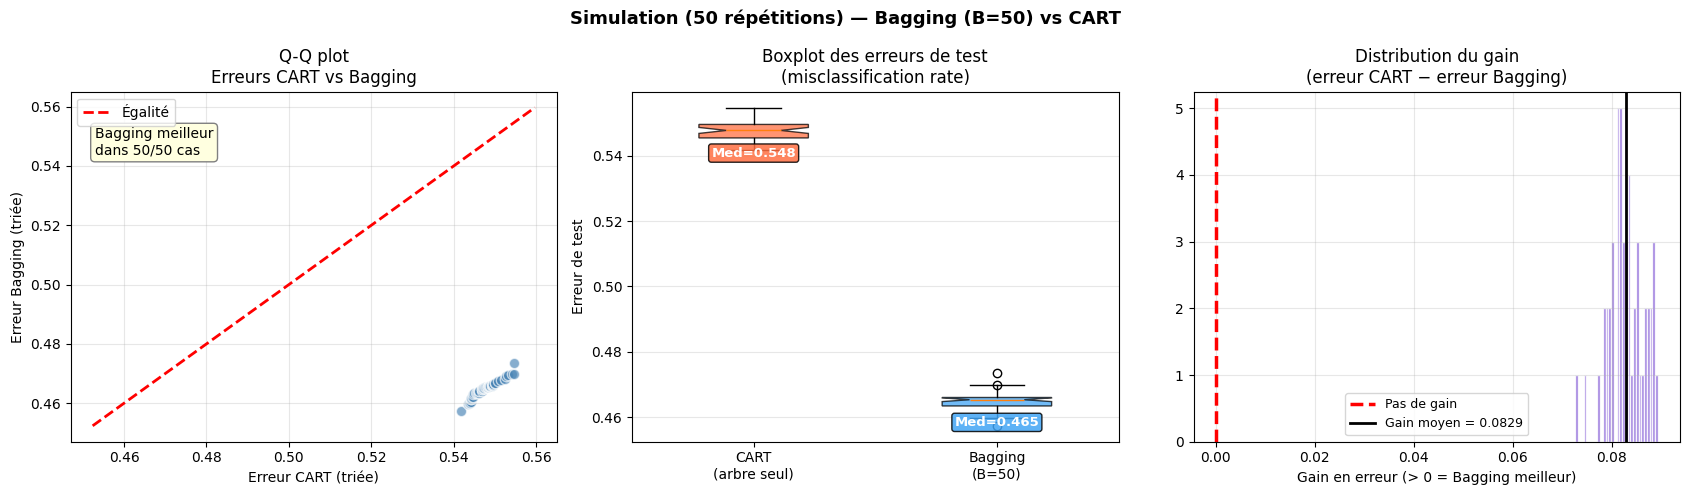

In [ ]:
N_SIM = 50
B_SIM = 50
errors_cart, errors_bag = [], []

for sim in range(N_SIM):
    Xtr, Xte, ytr, yte = train_test_split(
        X.values, y, test_size=0.3, random_state=sim, stratify=y
    )
    c = DecisionTreeClassifier(random_state=sim)
    c.fit(Xtr, ytr)
    errors_cart.append(1 - accuracy_score(yte, c.predict(Xte)))

    b = BaggingClassifier(estimator=DecisionTreeClassifier(),
                          n_estimators=B_SIM, bootstrap=True,
                          random_state=sim, n_jobs=-1)
    b.fit(Xtr, ytr)
    errors_bag.append(1 - accuracy_score(yte, b.predict(Xte)))

errors_cart = np.array(errors_cart)
errors_bag  = np.array(errors_bag)

print(f"  CART    : {errors_cart.mean():.4f} ± {errors_cart.std():.4f}")
print(f"  Bagging : {errors_bag.mean():.4f} ± {errors_bag.std():.4f}")
print(f"  Bagging < CART dans {np.sum(errors_bag < errors_cart)}/{N_SIM} simulations")

fig4, axes4 = plt.subplots(1, 3, figsize=(17, 5))
fig4.suptitle(f"Simulation ({N_SIM} répétitions) — Bagging (B={B_SIM}) vs CART",
              fontsize=13, fontweight='bold')

# Q-Q plot
axes4[0].scatter(np.sort(errors_cart), np.sort(errors_bag),
                 color='steelblue', alpha=0.65, s=55, edgecolors='white')
lims = [min(errors_cart.min(), errors_bag.min()) - 0.005,
        max(errors_cart.max(), errors_bag.max()) + 0.005]
axes4[0].plot(lims, lims, 'r--', lw=2, label='Égalité')
axes4[0].set_title("Q-Q plot\nErreurs CART vs Bagging")
axes4[0].set_xlabel("Erreur CART (triée)")
axes4[0].set_ylabel("Erreur Bagging (triée)")
axes4[0].legend()
axes4[0].grid(alpha=0.3)
n_better = np.sum(errors_bag < errors_cart)
axes4[0].annotate(f"Bagging meilleur\ndans {n_better}/{N_SIM} cas",
                  xy=(0.05, 0.82), xycoords='axes fraction', fontsize=10,
                  bbox=dict(boxstyle='round', fc='lightyellow', ec='gray'))

# Boxplot
bp4 = axes4[1].boxplot([errors_cart, errors_bag],
                       labels=['CART\n(arbre seul)', f'Bagging\n(B={B_SIM})'],
                       patch_artist=True, widths=0.45, notch=True)
bp4['boxes'][0].set_facecolor('#FF7043'); bp4['boxes'][0].set_alpha(0.75)
bp4['boxes'][1].set_facecolor('#42A5F5'); bp4['boxes'][1].set_alpha(0.75)
axes4[1].set_title("Boxplot des erreurs de test\n(misclassification rate)")
axes4[1].set_ylabel("Erreur de test")
for i, (errs, col) in enumerate(zip([errors_cart, errors_bag], ['#FF7043', '#42A5F5']), 1):
    axes4[1].text(i, np.median(errs) - 0.008,
                  f'Med={np.median(errs):.3f}', ha='center', fontsize=9.5,
                  fontweight='bold', color='white',
                  bbox=dict(boxstyle='round,pad=0.2', fc=col, alpha=0.85))
axes4[1].grid(axis='y', alpha=0.3)

# Distribution des différences
diffs = errors_cart - errors_bag
axes4[2].hist(diffs, bins=30, color='mediumpurple', edgecolor='white', alpha=0.85)
axes4[2].axvline(0,             color='red',    lw=2.5, linestyle='--', label='Pas de gain')
axes4[2].axvline(diffs.mean(),  color='black',  lw=2,   linestyle='-',
                 label=f'Gain moyen = {diffs.mean():.4f}')
axes4[2].set_title("Distribution du gain\n(erreur CART − erreur Bagging)")
axes4[2].set_xlabel("Gain en erreur (> 0 = Bagging meilleur)")
axes4[2].legend(fontsize=9)
axes4[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


═════════════════════════════════════════════════════════════════
  ESTIMATEURS DE PRÉCISION — Test / CV / OOB
═════════════════════════════════════════════════════════════════
  Erreur test (70/30)   : 0.4597
  5-fold CV             : 0.4585 ± 0.0030
  10-fold CV            : 0.4558 ± 0.0044
  OOB error             : 0.4580


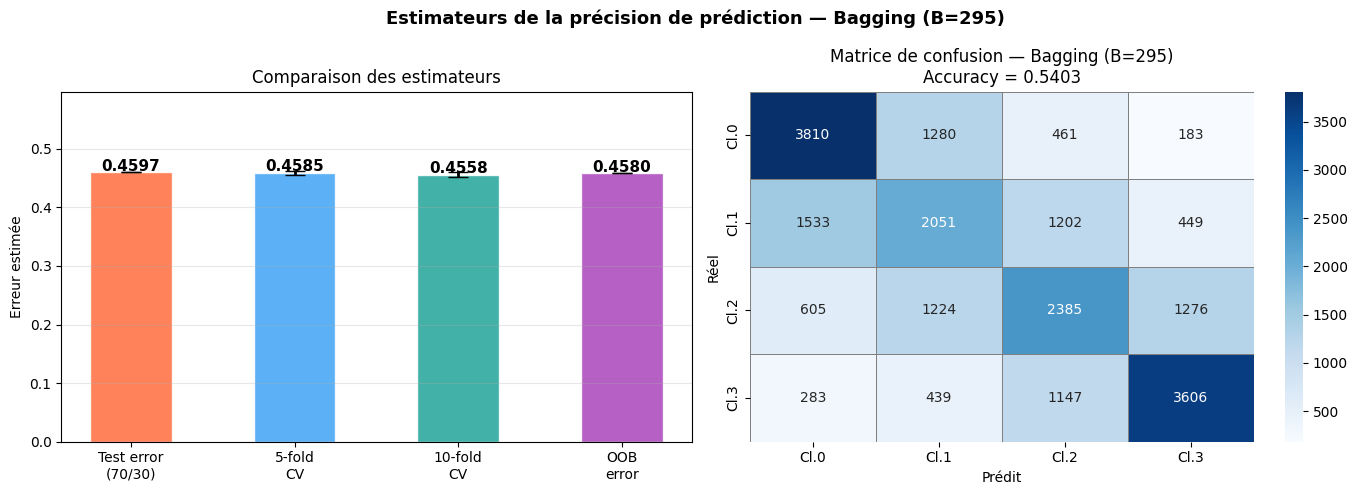

In [ ]:
print("\n" + "═"*65)
print("  ESTIMATEURS DE PRÉCISION — Test / CV / OOB")
print("═"*65)

B_FINAL = best_B

# Test error
bag_test = BaggingClassifier(estimator=DecisionTreeClassifier(),
                             n_estimators=B_FINAL, bootstrap=True,
                             random_state=42, n_jobs=-1)
bag_test.fit(X_train, y_train)
err_test = 1 - accuracy_score(y_test, bag_test.predict(X_test))

# CV 5 et 10 fold
cv_res = {}
for k in [5, 10]:
    bag_cv = BaggingClassifier(estimator=DecisionTreeClassifier(),
                               n_estimators=B_FINAL, bootstrap=True, random_state=42)
    scores = cross_val_score(bag_cv, X.values, y, cv=StratifiedKFold(k, shuffle=True, random_state=42),
                             scoring='accuracy', n_jobs=-1)
    cv_res[k] = 1 - scores

# OOB
bag_oob = BaggingClassifier(estimator=DecisionTreeClassifier(),
                            n_estimators=B_FINAL, bootstrap=True,
                            oob_score=True, random_state=42, n_jobs=-1)
bag_oob.fit(X.values, y)
err_oob = 1 - bag_oob.oob_score_

print(f"  Erreur test (70/30)   : {err_test:.4f}")
print(f"  5-fold CV             : {cv_res[5].mean():.4f} ± {cv_res[5].std():.4f}")
print(f"  10-fold CV            : {cv_res[10].mean():.4f} ± {cv_res[10].std():.4f}")
print(f"  OOB error             : {err_oob:.4f}")

labels5  = ['Test error\n(70/30)', '5-fold\nCV', '10-fold\nCV', 'OOB\nerror']
means5   = [err_test, cv_res[5].mean(), cv_res[10].mean(), err_oob]
stds5    = [0, cv_res[5].std(), cv_res[10].std(), 0]
colors5  = ['#FF7043', '#42A5F5', '#26A69A', '#AB47BC']

fig5, axes5 = plt.subplots(1, 2, figsize=(14, 5))
fig5.suptitle(f"Estimateurs de la précision de prédiction — Bagging (B={B_FINAL})",
              fontsize=13, fontweight='bold')

bars5 = axes5[0].bar(labels5, means5, color=colors5, edgecolor='white',
                     width=0.5, alpha=0.87)
axes5[0].errorbar(range(4), means5, yerr=stds5,
                  fmt='none', color='black', capsize=7, lw=2)
for bar, val in zip(bars5, means5):
    axes5[0].text(bar.get_x() + bar.get_width()/2, val + 0.003,
                  f'{val:.4f}', ha='center', fontsize=11, fontweight='bold')
axes5[0].set_ylabel("Erreur estimée")
axes5[0].set_title("Comparaison des estimateurs")
axes5[0].set_ylim(0, max(means5) * 1.3)
axes5[0].grid(axis='y', alpha=0.3)

# Matrice de confusion du meilleur modèle
y_pred_final = bag_test.predict(X_test)
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes5[1],
            xticklabels=CLASS_SHORT, yticklabels=CLASS_SHORT,
            linewidths=0.5, linecolor='gray')
axes5[1].set_title(f"Matrice de confusion — Bagging (B={B_FINAL})\n"
                   f"Accuracy = {1-err_test:.4f}")
axes5[1].set_xlabel("Prédit")
axes5[1].set_ylabel("Réel")

plt.tight_layout()
plt.show()